In [1]:
!sudo /bin/bash -c "(source /venv/bin/activate; pip install --quiet jupyterlab-vim)"
!jupyter labextension enable

In [ ]:
%load_ext autoreload
%autoreload 2

import pymc as pm
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats

print("pymc.version=", pm.__version__)
print("arviz.version=", az.__version__)

In [39]:
plt.rcParams['figure.figsize'] = [8, 3]

dir_name = "/aux/code/book.2018.Martin.Bayesian_Analysis_with_Python.2e"

# Chap1: Thinking probabilistically

# Chap 2: Programming probabilistically

# Chap 3: Hierarchical models

# Chap 4: Modeling with lines

# Chap 5: Model Comparison

## Posterior predictive check

Text(0, 0.5, 'y')

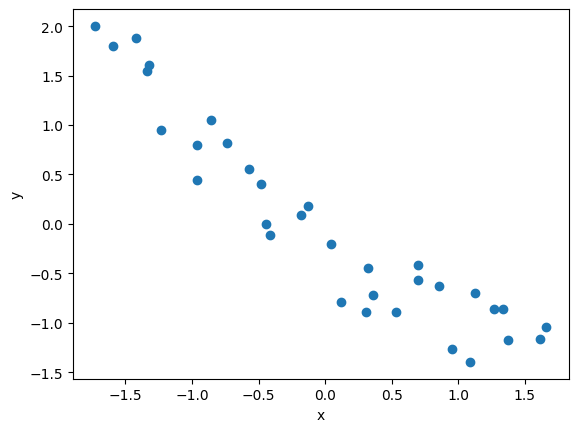

In [5]:
# Load some data.
dummy_data = np.loadtxt('data/dummy.csv')
x = dummy_data[:, 0]
y = dummy_data[:, 1]

# Transform the data applying n-th power and stacking (these are the model features).
order = 2
x_p = np.vstack([x**i for i in range(1, order + 1)])

# Normalize all the data.
x_c = (x_p - x_p.mean(axis=1, keepdims=True)) / x_p.std(axis=1, keepdims=True)
y_c = (y - y.mean()) / y.std()

# Plot the 0-order data (i.e., the original one).
plt.scatter(x_c[0], y_c)
plt.xlabel('x')
plt.ylabel('y')

In [8]:
# Linear model.
with pm.Model() as model_l:
    alpha = pm.Normal('alpha', mu=0, sigma=1)
    beta = pm.Normal('beta', mu=0, sigma=10)
    sigma = pm.HalfNormal('sigma', 5)
    #
    mu = alpha + beta * x_c[0]
    #
    y_pred = pm.Normal('y_pred', mu=mu, sigma=sigma, observed=y_c)
    #
    idata_l = pm.sample(2000, idata_kwargs={"log_likelihood": True})
    idata_l.extend(pm.sample_posterior_predictive(idata_l))
    

# Quadratic model.
with pm.Model() as model_p:
    alpha = pm.Normal('alpha', mu=0, sigma=1)
    # Beta is a 2-dim vector.
    beta = pm.Normal('beta', mu=0, sigma=10, shape=order)
    sigma = pm.HalfNormal('sigma', 5)
    #
    mu = alpha + pm.math.dot(beta, x_c)
    #
    y_pred = pm.Normal('y_pred', mu=mu, sigma=sigma, observed=y_c)
    #
    idata_q = pm.sample(2000, idata_kwargs={"log_likelihood": True})
    idata_q.extend(pm.sample_posterior_predictive(idata_q))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, sigma]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 1 seconds.
Sampling: [y_pred]


Output()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, sigma]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 2 seconds.
Sampling: [y_pred]


Output()

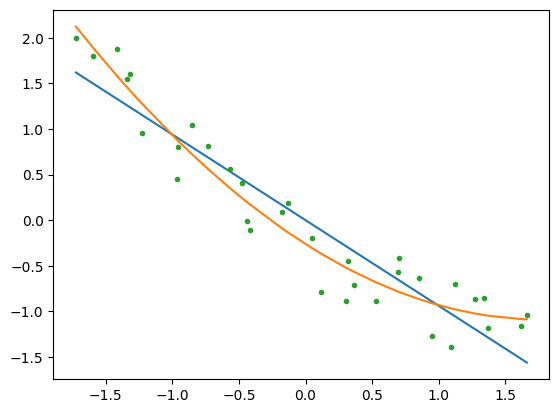

In [11]:
# Sample.
x_new = np.linspace(x_c[0].min(), x_c[0].max(), 100)

# Posterior.
posterior_l = az.extract(idata_l)
posterior_p = az.extract(idata_q)
#print(posterior_l)

# Linear model.
alpha_l_post = posterior_l["alpha"].mean().item()
beta_l_post = posterior_l["beta"].mean().item()
y_l_post = alpha_l_post + beta_l_post * x_new

plt.plot(x_new, y_l_post, "C0", label="linear model")

# Quadratic model.
alpha_p_post = posterior_p["alpha"].mean().item()
beta_p_post = posterior_p["beta"].mean("sample")
idx = np.argsort(x_c[0])
y_p_post = alpha_p_post + np.dot(beta_p_post, x_c)

plt.plot(x_c[0][idx], y_p_post[idx], "C1", label="quadratic model")

# Plot data.
plt.plot(x_c[0], y_c, "C2.")

## KDE for posterior predictive check

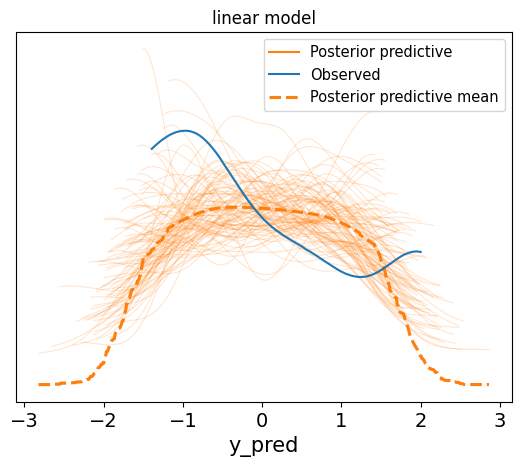

In [16]:
az.plot_ppc(idata_l, num_pp_samples=100, colors=["C1", "C0", "C1"])
plt.title("linear model");

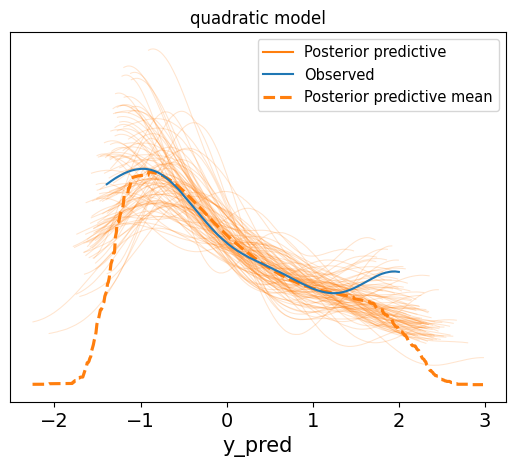

In [17]:
az.plot_ppc(idata_q, num_pp_samples=100, colors=["C1", "C0", "C1"])
plt.title("quadratic model");

In [24]:
#help(az.plot_bpv)

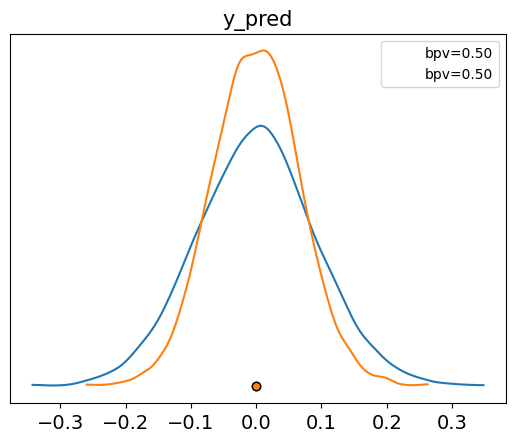

In [32]:
colors = ["C0", "C1"]
idatas = [idata_l, idata_q]

fig, axes = plt.subplots(1, 1)

for idata, c in zip(idatas, colors):
    # Plot Bayesian p-value.
    az.plot_bpv(idata, kind="t_stat", t_stat="mean", ax=axes, color=c)

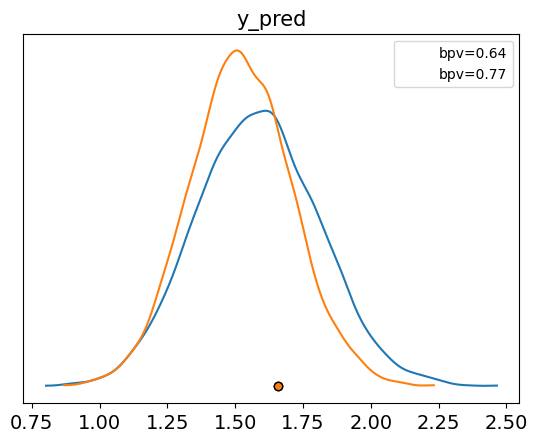

In [33]:
def iqr(x, a=-1):
    """interquartile range"""
    return np.subtract(*np.percentile(x, [75, 25], axis=a))

fig, axes = plt.subplots(1, 1)

for idata, c in zip(idatas, colors):
    # Plot Bayesian p-value.
    az.plot_bpv(idata, kind="t_stat", t_stat=iqr, ax=axes, color=c)

### P-value with entire distribution

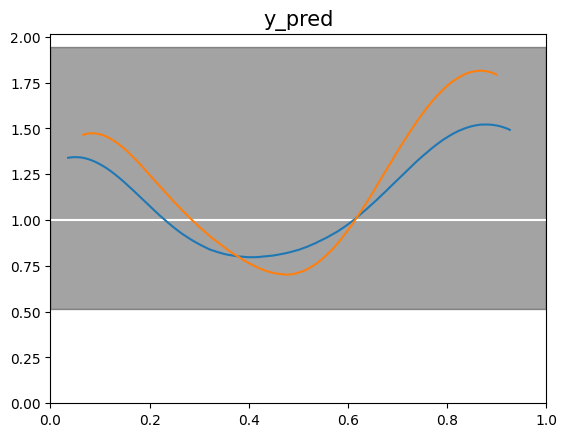

In [34]:
fig, ax = plt.subplots()

for idata, c in zip(idatas, colors):
    az.plot_bpv(idata, color=c, ax=ax)

### WAIC

In [48]:
waic_l = az.waic(idata_l)
waic_l

Computed from 8000 posterior samples and 33 observations log-likelihood matrix.

          Estimate       SE
elpd_waic   -14.38     2.65
p_waic        2.45        -

In [49]:
waic_q = az.waic(idata_q)
waic_q

Computed from 8000 posterior samples and 33 observations log-likelihood matrix.

          Estimate       SE
elpd_waic    -4.46     2.33
p_waic        2.56        -

- We get the the ELPD and the number of parameters

### LOO

In [50]:
loo_l = az.loo(idata_l)
loo_l

Computed from 8000 posterior samples and 33 observations log-likelihood matrix.

         Estimate       SE
elpd_loo   -14.41     2.66
p_loo        2.47        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.70]   (good)       33  100.0%
   (0.70, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%

In the first section
- The first row is ELPD
- The second row is the effective number of parameters

In the second section, there is the Pareto k diagnostic
- Since all the values are between 0 and 0.7, the approximation can be trusted

In [51]:
loo_q = az.loo(idata_q)
loo_q

Computed from 8000 posterior samples and 33 observations log-likelihood matrix.

         Estimate       SE
elpd_loo    -4.49     2.33
p_loo        2.59        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.70]   (good)       33  100.0%
   (0.70, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%

### Comparing models

In [54]:
cmp_df = az.compare({
    "model_l": idata_l,
    "model_q": idata_q})
display(cmp_df)

,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
model_q,0,-4.489300,2.593636,0.000000,1.0,2.334078,0.000000,False,log
model_l,1,-14.409936,2.473368,9.920636,0.0,2.660504,2.654703,False,log


- rank = order of the models from best to worst

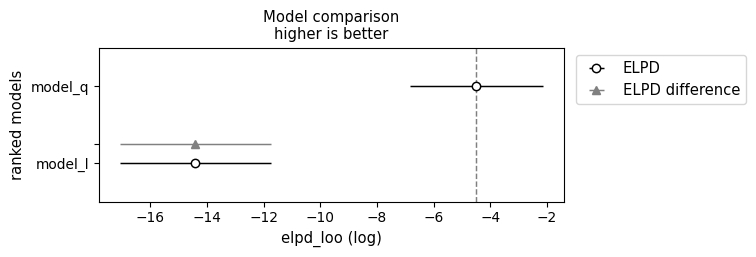

In [57]:
az.plot_compare(cmp_df);

### Overfitting

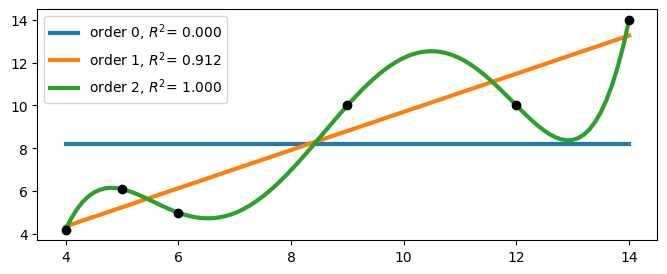

In [44]:
_, ax = plt.subplots(1, 1)

# Data.
x0 = np.array([4.0, 5.0, 6.0, 9.0, 12, 14.0])
y0 = np.array([4.2, 6.1, 5.0, 10.0, 10, 14.0])
ax.plot(x0, y0, "ko", zorder=3)

# Learn 3 models.
order = [0, 1, 5]
x_n = np.linspace(x0.min(), x0.max(), 100)
ps = []
for i in order:
    # Learn the models.
    p = np.polynomial.Polynomial.fit(x0, y0, deg=i)
    ps.append(p)

# 
def plot_models(x0, y0, ps):
    for i in range(len(order)):
        p = ps[i]
        # Evaluate on the raw data.
        yhat = p(x0)
        # Estimate the error between the estimates and the true values.
        ss_regression = np.sum((yhat - y0) ** 2)
        # Compute R^2.
        ybar = np.mean(y0)
        ss_total = np.sum((ybar - y0) ** 2)
        r2 = 1 - ss_regression / ss_total
        #
        ax.plot(x_n, p(x_n), label=f"order {i}, $R^2$= {r2:.3f}", lw=3)
    ax.legend(loc=2)


plot_models(x0, y0, ps)

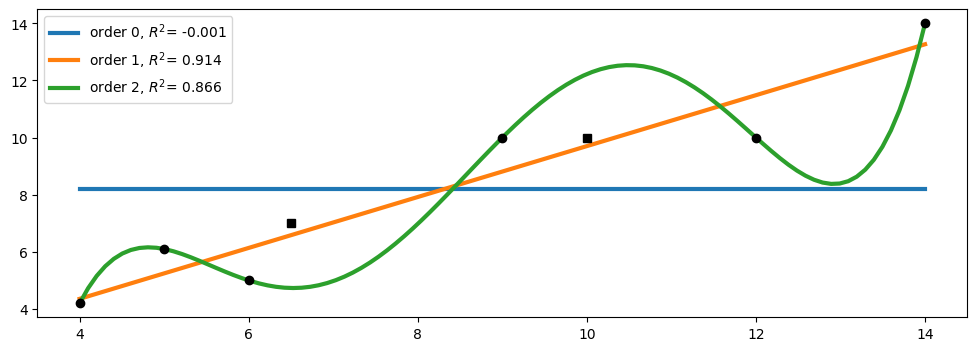

In [46]:
# Plot the in-sample data and the out-of-sample data.
_, ax = plt.subplots(figsize=(12, 4))
x_ = np.array([6.5, 10])
y_ = np.array([7, 10])

ax.plot(x0, y0, "ko", zorder=3)
ax.plot(x_, y_, "ks", zorder=3)

x1 = np.concatenate((x0, x_))
y1 = np.concatenate((y0, y_))

plot_models(x1, y1, ps)

## Model averaging

In [58]:
idatas = [idata_l, idata_q]
weights = [0.35, 0.65]
idata_w = az.weight_predictions(idatas, weights)

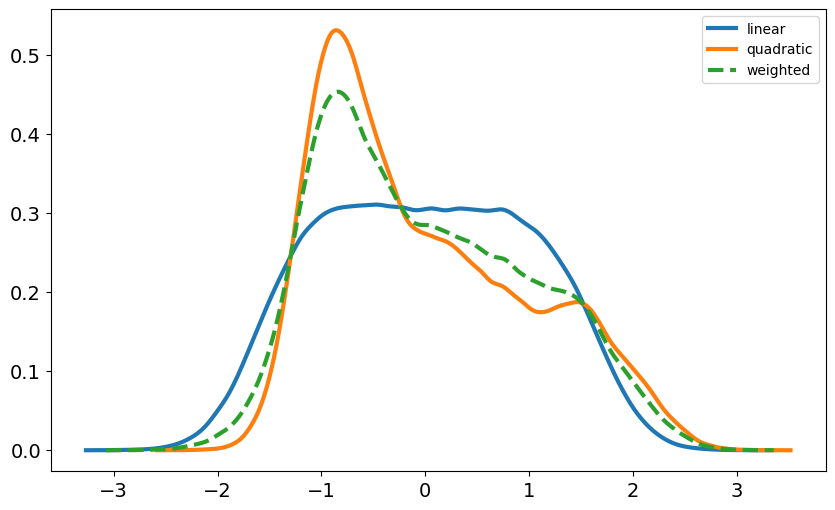

In [62]:
# Plot the KDE of the posterior predictive.
_, ax = plt.subplots(figsize=(10, 6))

# Linear.
az.plot_kde(
    idata_l.posterior_predictive["y_pred"].values,
    plot_kwargs={"color": "C0", "lw": 3},
    label="linear",
    ax=ax,
)

# Quadratic.
az.plot_kde(
    idata_q.posterior_predictive["y_pred"].values,
    plot_kwargs={"color": "C1", "lw": 3},
    label="quadratic",
    ax=ax,
)

# Weighted.
az.plot_kde(
    idata_w.posterior_predictive["y_pred"].values,
    plot_kwargs={"color": "C2", "lw": 3, "ls": "--"},
    label="weighted",
    ax=ax,
)

plt.legend();

## Computing Bayes factors

In [ ]:
coins = 30
heads = 9
# A vector of tails and heads.
y_d = np.repeat([0, 1], [coins - heads, heads])
print(y_d)

In [ ]:
with pm.Model() as model_BF:
    # The hyper prior is that the models are equally probably.
    p = np.array([0.5, 0.5])
    model_index = pm.Categorical('model_index', p=p)
    # The models have a different likelihood.
    m_0 = (4, 8)
    m_1 = (8, 4)
    m = pm.math.switch(pm.math.eq(model_index, 0), m_0, m_1)
    # a priori
    theta = pm.Beta('theta', m[0], m[1])
    # likelihood
    y = pm.Bernoulli('y', theta, observed=y_d)
    trace_BF = pm.sample(5000)
    
az.plot_trace(trace_BF);

In [ ]:
p_M1 = trace_BF.posterior['model_index'][0].mean()
p_M1 = p_M1.values
p_M0 = 1 - p_M1
print(p_M0, p_M1)
# Account also for the priors.
bayes_factor = (p_M0 / p_M1) * (p[1] / p[0])
print(bayes_factor)

# There is strong evidence that the first model is correct.

## Using sequential Monte Carlo to compute Bayes factors

In [ ]:
# TODO: pymc doesn't have pm.SMC
# https://www.pymc.io/projects/examples/en/latest/samplers/SMC2_gaussians.html

# with pm.Model() as model_BF_0:
#     theta = pm.Beta('theta', 4, 8)
#     y = pm.Bernoulli('y', theta, observed=y_d)
#     trace_BF_0 = pm.sample(2500, step=pm.SMC())
    
# with pm.Model() as model_BF_1:
#     theta = pm.Beta('theta', 8, 4)
#     y = pm.Bernoulli('y', theta, observed=y_d)
#     trace_BF_1 = pm.sample(2500, step=pm.SMC())
    
# model_BF_0.marginal_likelihood / model_BF_1.marginal_likelihood